<a href="https://colab.research.google.com/github/UEPP40/PUM/blob/Pietruszkiewicz/Copy_of_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
instalacja dodatkowych bibliotek
```



In [1]:
!pip install lime
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=23da5800697bf145ff2e0762f92c6625d8bc3459a2e6a0f65dfa3608b75a4fde
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.2 MB/s eta 0:00:00


importy bibliotek

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# library to feature importance
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap

# import the regressor and metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import datasets, ensemble
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

dane dotyczące cen domów w Kalifornii

In [11]:
# Load the dataset
data = pd.read_csv("california_housing_train.csv")

# Display basic information about the dataset
print(data.info())
print(data.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB
None
(17000, 9)


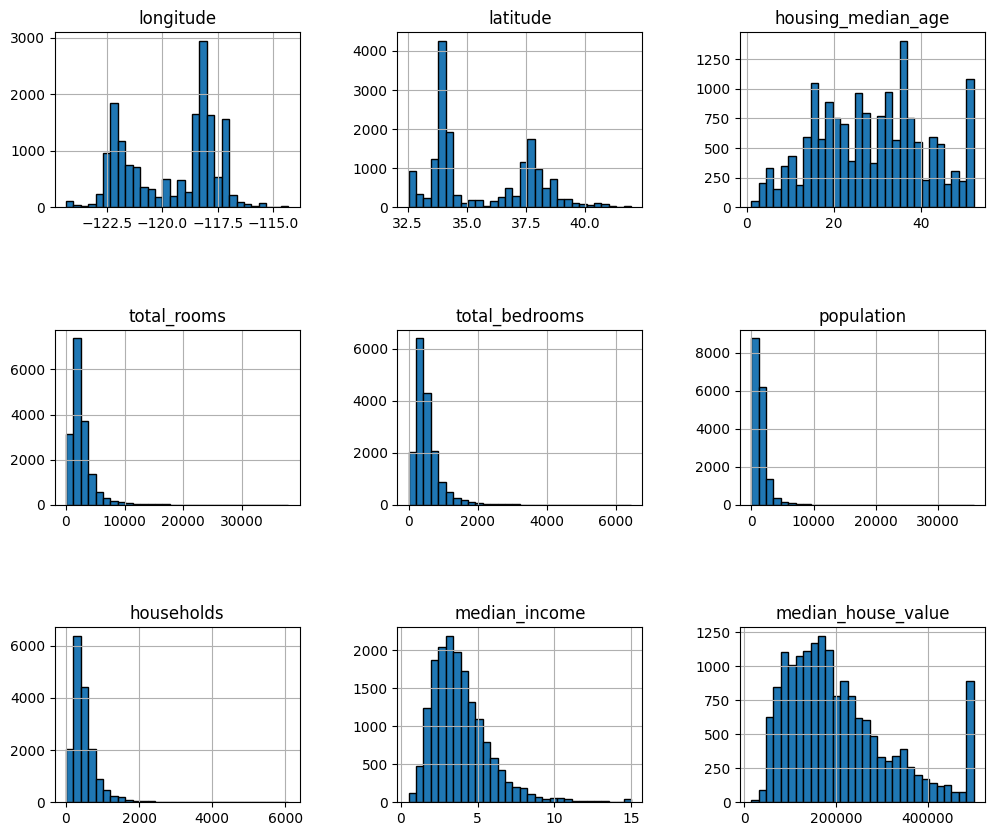

In [4]:
import matplotlib.pyplot as plt


data.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

[0]	validation_0-rmse:116030.09967


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1000]	validation_0-rmse:73559.69856
[2000]	validation_0-rmse:68299.78864
[3000]	validation_0-rmse:65272.90834
[4000]	validation_0-rmse:63172.76180
[5000]	validation_0-rmse:61657.52897
[6000]	validation_0-rmse:60503.18904
[7000]	validation_0-rmse:59617.35377
[8000]	validation_0-rmse:58925.83504
[9000]	validation_0-rmse:58417.86250
[9999]	validation_0-rmse:57986.80504
The mean squared error (RMSE) of the model on the validation set: 57986.3450
The median absolute error (MAE) of the model on the validation set: 31229.7969


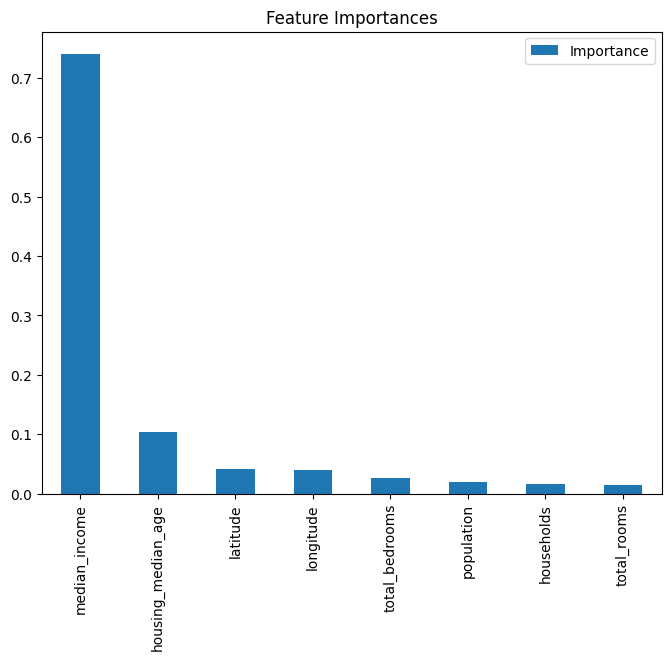

In [9]:
# Replace "no" with NaN in the 'households' column
data['households'].replace("no", np.nan, inplace=True)

# Fill missing values in 'total_bedrooms' with the column mean
data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].mean())

# Define features (X) and target (y)
X = data.drop(["median_house_value"], axis=1)
y = data['median_house_value']

# Split the data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=13
)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Create a regressor object
model_depth1 = xgb.XGBRegressor(
    max_depth=1,
    learning_rate=0.01,
    subsample=0.5,
    n_estimators=10000,
    base_score=y_train.mean(),
)

# Fit the regressor with training data
model_depth1.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    verbose=1000,
    early_stopping_rounds=20,
)

# Predict on the validation set
y_pred = model_depth1.predict(X_valid)

# Calculate RMSE and median absolute error
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
median_err = median_absolute_error(y_valid, y_pred)

print("The mean squared error (RMSE) of the model on the validation set: {:.4f}".format(rmse))
print("The median absolute error (MAE) of the model on the validation set: {:.4f}".format(median_err))

# Feature importances
feat_importances = pd.DataFrame(model_depth1.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importances
feat_importances.plot(kind='bar', figsize=(8, 6))
plt.title("Feature Importances")
plt.show()

100%|===================| 5094/5100 [03:31<00:00]       

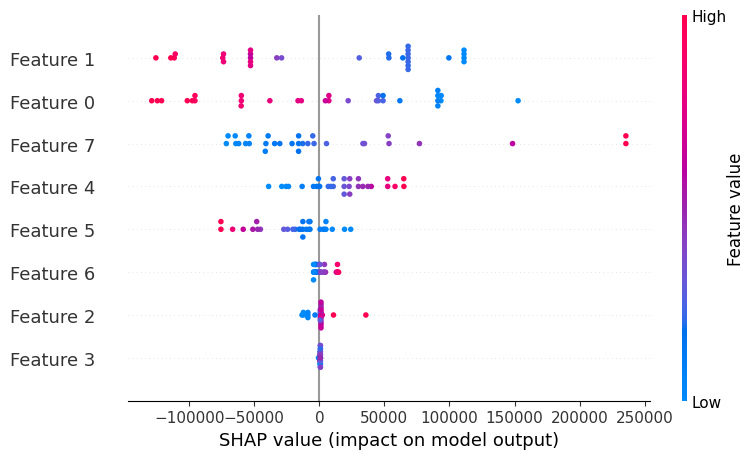

In [18]:
import shap

# Initialize JavaScript visualization in the notebook
shap.initjs()

# Create the explainer
explainer = shap.Explainer(model_depth1, X_train)

# Evaluate SHAP values
shap_values = explainer(X_valid)

# Check SHAP values for the first 30 instances
shap_values_30 = shap_values[:30]

# Display the SHAP values
shap.summary_plot(shap_values_30, X_valid[:30])


In [22]:
import lime.lime_tabular

# Generate explanation
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=feature_names,  # Replace feature_names with your list of feature names
    class_names=['median_house_value'],  # Replace with your list of class names if applicable
    verbose=True,
    mode='regression'  # Adjust the mode based on your use case
)

# Choose the 5th instance for explanation
instance_to_explain = X_train.iloc[4]


# Plot the explanation
explanation.show_in_notebook(show_table=True, show_all=False)

# To save the plot as an image
explanation.save_to_file('lime_explanation.html')

NameError: name 'feature_names' is not defined

In [23]:
shap_values = explainer.shap_values(X_test)
print("Variable Importance Plot - Global Interpretation")
#graph summary


NameError: name 'X_test' is not defined